# Using Various Macheiene Learning Methods to Classify Pitches Thrown By The Colorado Rockies From 2016 - 2023 MLB Seasons

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import sklearn
import numpy as np
from sklearn.linear_model import LinearRegression
from mlxtend.feature_selection import SequentialFeatureSelector as sfs
from sklearn.preprocessing import OrdinalEncoder
from sklearn.naive_bayes import MultinomialNB, CategoricalNB
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score
from sklearn.linear_model import RidgeClassifier, LogisticRegression
import os

## Data Collection

#### For project 1 I collected my data from the statcast search on the baseball savant website by searching for every pitch thrown by the Colorado Rockies in 2023 sorted by pitcher. I then downloaded the csv file for every single pitcher which included each individual pitch thrown by that player and then combined all of the individual players csv files into one single csv file that provided me with every pitch thrown by the Colorado Rockies as a team in 2023 using the code below. This time I want to expand my data set to contain more years and attempt to use some different methods so for this project, I will be using pitching data from 2015 - 2023 excluding the 2020 shortened season since that season didn't have a full sample size. This data was collected the same way which was by downloading each individual pitcher's data from the baseball savant website and then combining them. This time around getting all the data took a lot longer just because there was about five times the amount of csvs to download. This time I will be using naive bayes again since that worked pretty well last time but, instead of using KNN since that didn't work well last time I am going to try using logistic regression as well as random forests and compare the results between those two methods as well as naive bayes to see if I can accurately predict pitch types.  

In [2]:
directory = os.getcwd()
directory

'C:\\Users\\garyp'

In [3]:
directory = 'C:\\Users\\garyp\\rockies pitchers 2015 - 2023 data'
directory
os.chdir(directory)
if not os.path.exists('rockies2015-2023pitchers.csv'):
    csv_files = [file for file in os.listdir() if file.endswith('.csv')]
    dfs = []
    for csv_file in csv_files:
        df = pd.read_csv(csv_file, low_memory=False)
        dfs.append(df)
    combined_df = pd.concat(dfs, ignore_index=True)
    combined_df.to_csv('rockies2015-2023pitchers.csv', index=False)
else:
    print("file already exists no need to combine again")

file already exists no need to combine again


#### I then made sure the csv's combined correctly.

In [4]:
df = pd.read_csv('rockies2015-2023pitchers.csv')
df.head()

C:\Users\garyp\AppData\Local\Temp\ipykernel_53668\2173081814.py:1: DtypeWarning: Columns (43) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv('rockies2015-2023pitchers.csv')


,pitch_type,game_date,release_speed,release_pos_x,release_pos_z,player_name,batter,pitcher,events,description,...,fld_score,post_away_score,post_home_score,post_bat_score,post_fld_score,if_fielding_alignment,of_fielding_alignment,spin_axis,delta_home_win_exp,delta_run_exp
0,FF,2015-07-24,94.6,-1.62,6.47,"Hawkins, LaTroy",571740,115629,field_out,hit_into_play,...,3,4,3,4,3,Standard,Standard,NaN,0.042,-0.278
1,SL,2015-07-24,90.1,-2.09,6.30,"Hawkins, LaTroy",571740,115629,NaN,foul,...,3,4,3,4,3,Standard,Standard,NaN,0.000,0.000
2,FF,2015-07-24,94.8,-1.81,6.39,"Hawkins, LaTroy",571740,115629,NaN,bunt_foul_tip,...,3,4,3,4,3,Strategic,Strategic,NaN,0.093,-0.161
3,CH,2015-07-24,86.3,-1.76,6.56,"Hawkins, LaTroy",571740,115629,NaN,ball,...,3,4,3,4,3,Strategic,Strategic,NaN,0.000,0.066
4,CH,2015-07-24,87.2,-1.67,6.66,"Hawkins, LaTroy",571740,115629,NaN,ball,...,3,4,3,4,3,Strategic,Strategic,NaN,0.000,0.041


#### There seems to be an issue with column 43 having mixed data types so I will see which column that is and if it's unimportant in predctiing pitch type I will remove it later. 

In [5]:
col42 = df.columns[42]
col42

'umpire'

In [6]:
players = df['player_name'].unique()
players

array(['Hawkins, LaTroy', 'Betancourt, Rafael', 'Qualls, Chad',
       'Motte, Jason', 'Desmond, Ian', 'Laffey, Aaron', 'Reynolds, Mark',
       'Neshek, Pat', 'Brown, Brooks', 'Abad, Fernando', 'Oh, Seunghwan',
       'Castro, Simon', 'Rondon, Jorge', 'Gurka, Jason', 'Hand, Brad',
       'Melville, Tim', 'Grichuk, Randal', 'Matzek, Tyler',
       'Brothers, Rex', 'Carasiti, Matt', 'Givens, Mychal', 'Koch, Matt',
       'Pazos, James', 'Pounders, Brooks', 'Johnson, Pierce',
       'Rosscup, Zac', 'Kahnle, Tommy', 'Roberts, Ken', 'Johnson, DJ',
       'Castro, Harold', 'Howard, Sam', 'Castro, Miguel', 'Tinoco, Jesus',
       'Goudeau, Ashton', 'Castellani, Ryan', 'Parsons, Wes',
       'Bowden, Ben', 'Carle, Shane', 'Sheffield, Jordan',
       'Fernández, Julian', 'Harvey, Joe', 'Doyle, Tommy', 'Vasto, Jerry',
       'Smith, Chad', 'Davis, Noah', 'Calvo, Blair', 'Santos, Antonio',
       'Kauffmann, Karl', 'Pint, Riley', 'Hollowell, Gavin',
       'Garcia, Rico', 'Diehl, Phillip', 'Trej

In [7]:
playersCount = len(players)
playersCount

107

## Data Cleaning

#### To start I printed out all of the columns in my data set in order to see what variables could be potential predictors. 

In [8]:
columnNames = df.columns
columnNames

Index(['pitch_type', 'game_date', 'release_speed', 'release_pos_x',
       'release_pos_z', 'player_name', 'batter', 'pitcher', 'events',
       'description', 'spin_dir', 'spin_rate_deprecated',
       'break_angle_deprecated', 'break_length_deprecated', 'zone', 'des',
       'game_type', 'stand', 'p_throws', 'home_team', 'away_team', 'type',
       'hit_location', 'bb_type', 'balls', 'strikes', 'game_year', 'pfx_x',
       'pfx_z', 'plate_x', 'plate_z', 'on_3b', 'on_2b', 'on_1b',
       'outs_when_up', 'inning', 'inning_topbot', 'hc_x', 'hc_y',
       'tfs_deprecated', 'tfs_zulu_deprecated', 'fielder_2', 'umpire', 'sv_id',
       'vx0', 'vy0', 'vz0', 'ax', 'ay', 'az', 'sz_top', 'sz_bot',
       'hit_distance_sc', 'launch_speed', 'launch_angle', 'effective_speed',
       'release_spin_rate', 'release_extension', 'game_pk', 'pitcher.1',
       'fielder_2.1', 'fielder_3', 'fielder_4', 'fielder_5', 'fielder_6',
       'fielder_7', 'fielder_8', 'fielder_9', 'release_pos_y',
       'estima

In [9]:
dfDim = df.shape
dfDim

(189070, 92)

#### Using the csv documentation on the baseball savant website I ended up getting rid of all of the columns that won't have any values because of the new system that doesn't use a some of the columns provided. Once I took all of those out I ended up selecting columns that I thought could potetnially be predictors of a certain pitch. In the end I selected 29 predictors and all of them fit into one of three categories which included, how the ball comes out of the pitchers hand, how the ball travels to the plate, or the situation of the game. I also removed umpire which is the column I had issues with earlier.

In [10]:
predictorColumns = ['pitch_name', 'release_speed', 'release_pos_x',
       'release_pos_z', 'batter', 'pitcher', 'zone','stand', 'p_throws',
        'balls', 'strikes', 'pfx_x',
       'pfx_z', 'plate_x', 'plate_z',
       'outs_when_up', 'inning',
       'vx0', 'vy0', 'vz0', 'ax', 'ay', 'az', 'effective_speed',
       'release_spin_rate', 'release_extension', 'release_pos_y','at_bat_number', 'pitch_number',
        'bat_score', 'fld_score', 'spin_axis']
df = df[predictorColumns]
print(df.shape)
df.head()

(189070, 32)


,pitch_name,release_speed,release_pos_x,release_pos_z,batter,pitcher,zone,stand,p_throws,balls,...,az,effective_speed,release_spin_rate,release_extension,release_pos_y,at_bat_number,pitch_number,bat_score,fld_score,spin_axis
0,4-Seam Fastball,94.6,-1.62,6.47,571740,115629,7,L,R,2,...,-19.761,95.3,2090.0,6.2,54.5,65,6,4,3,NaN
1,Slider,90.1,-2.09,6.30,571740,115629,9,L,R,2,...,-27.449,89.1,2153.0,5.9,54.5,65,5,4,3,NaN
2,4-Seam Fastball,94.8,-1.81,6.39,571740,115629,5,L,R,2,...,-21.558,94.2,2062.0,6.2,54.5,65,4,4,3,NaN
3,Changeup,86.3,-1.76,6.56,571740,115629,13,L,R,1,...,-26.552,85.8,1695.0,6.0,54.5,65,3,4,3,NaN
4,Changeup,87.2,-1.67,6.66,571740,115629,13,L,R,0,...,-21.426,86.5,1794.0,6.0,54.5,65,2,4,3,NaN


#### I then looked for missing values

In [11]:
df.isnull().sum(axis=0)

pitch_name               0
release_speed            0
release_pos_x            0
release_pos_z            0
batter                   0
pitcher                  0
zone                     0
stand                    0
p_throws                 0
balls                    0
strikes                  0
pfx_x                    0
pfx_z                    0
plate_x                  0
plate_z                  0
outs_when_up             0
inning                   0
vx0                      0
vy0                      0
vz0                      0
ax                       0
ay                       0
az                       0
effective_speed       1321
release_spin_rate     5327
release_extension     1309
release_pos_y            0
at_bat_number            0
pitch_number             0
bat_score                0
fld_score                0
spin_axis            25855
dtype: int64

#### I'm going to remove spin_axis as a predictor because 25855 is a ton of observations to lose and I think it's more important to have more observations in this case given the amount of other predictors we have even though I think that spin axis is an important predictor.

In [12]:
df = df.drop('spin_axis', axis = 1)
df

,pitch_name,release_speed,release_pos_x,release_pos_z,batter,pitcher,zone,stand,p_throws,balls,...,ay,az,effective_speed,release_spin_rate,release_extension,release_pos_y,at_bat_number,pitch_number,bat_score,fld_score
0,4-Seam Fastball,94.6,-1.62,6.47,571740,115629,7,L,R,2,...,21.917,-19.761,95.3,2090.0,6.2,54.5,65,6,4,3
1,Slider,90.1,-2.09,6.30,571740,115629,9,L,R,2,...,28.148,-27.449,89.1,2153.0,5.9,54.5,65,5,4,3
2,4-Seam Fastball,94.8,-1.81,6.39,571740,115629,5,L,R,2,...,30.756,-21.558,94.2,2062.0,6.2,54.5,65,4,4,3
3,Changeup,86.3,-1.76,6.56,571740,115629,13,L,R,1,...,24.784,-26.552,85.8,1695.0,6.0,54.5,65,3,4,3
4,Changeup,87.2,-1.67,6.66,571740,115629,13,L,R,0,...,25.075,-21.426,86.5,1794.0,6.0,54.5,65,2,4,3
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
189065,Slider,84.7,1.35,6.09,435062,456071,4,R,L,0,...,23.550,-28.845,83.3,1825.0,5.4,54.5,36,1,4,0
189066,Changeup,85.7,1.65,6.07,276519,456071,9,R,L,1,...,26.428,-26.223,83.9,1882.0,5.4,54.5,35,2,4,0
189067,Sinker,90.3,1.62,6.38,276519,456071,12,R,L,0,...,26.956,-17.573,88.7,1893.0,5.3,54.5,35,1,4,0
189068,Slider,85.1,1.63,6.11,592626,456071,8,L,L,0,...,24.718,-21.713,82.8,1087.0,4.9,54.5,31,2,4,0


#### Now I'll remove the missing values

In [13]:
df.isnull().sum(axis=0)

pitch_name              0
release_speed           0
release_pos_x           0
release_pos_z           0
batter                  0
pitcher                 0
zone                    0
stand                   0
p_throws                0
balls                   0
strikes                 0
pfx_x                   0
pfx_z                   0
plate_x                 0
plate_z                 0
outs_when_up            0
inning                  0
vx0                     0
vy0                     0
vz0                     0
ax                      0
ay                      0
az                      0
effective_speed      1321
release_spin_rate    5327
release_extension    1309
release_pos_y           0
at_bat_number           0
pitch_number            0
bat_score               0
fld_score               0
dtype: int64

In [14]:
df = df.dropna()
df.shape

(183708, 31)

#### Checking how many different pitch types there are and the count of each

In [15]:
pitchTypeCount = df['pitch_name'].value_counts()
pitchTypeCount

pitch_name
4-Seam Fastball     73739
Slider              32615
Sinker              25870
Changeup            17868
Cutter              12080
Curveball           10410
Knuckle Curve        5901
Sweeper              2948
Split-Finger         1744
Intentional Ball      266
Forkball              171
Slurve                 33
Eephus                 32
Pitch Out              29
Slow Curve              2
Name: count, dtype: int64

In [16]:
df['pitch_name'].value_counts(normalize=True)

pitch_name
4-Seam Fastball     0.401392
Slider              0.177537
Sinker              0.140821
Changeup            0.097263
Cutter              0.065757
Curveball           0.056666
Knuckle Curve       0.032122
Sweeper             0.016047
Split-Finger        0.009493
Intentional Ball    0.001448
Forkball            0.000931
Slurve              0.000180
Eephus              0.000174
Pitch Out           0.000158
Slow Curve          0.000011
Name: proportion, dtype: float64

#### When looking at the counts of the different pitch names I noticed that a few pitch names had very few observations which could cause issues with our train and test splits. For example, if all of the 32 eephus or slow curve pitches end up out of the train split then our test split will have more pitch names and that will cause issues so for that reason I'm going to remove slow curve, pitch out, eephus, intentional balls, and slurves. Another reason as to why I'm removing these pitch names is because intentional balls and pitch outs haven't been thrown since 2017 because of a rule change that allowed teams to just say they want to walk a batter, slow curves and slurves are just variations of curve balls, and the eephus is just a ball thrown as slow as you can and is usually mis classified when a position player pitches rather than an actual pitcher since position players typically throw slower than real pitchers. 

In [17]:
df = df[df['pitch_name'] != "Slow Curve"]
df = df[df['pitch_name'] !="Pitch Out"]
df = df[df['pitch_name'] != "Eephus"]
df = df[df['pitch_name'] != "Slurve"]
df = df[df['pitch_name'] != "Intentional Ball"]
df 

,pitch_name,release_speed,release_pos_x,release_pos_z,batter,pitcher,zone,stand,p_throws,balls,...,ay,az,effective_speed,release_spin_rate,release_extension,release_pos_y,at_bat_number,pitch_number,bat_score,fld_score
0,4-Seam Fastball,94.6,-1.62,6.47,571740,115629,7,L,R,2,...,21.917,-19.761,95.3,2090.0,6.2,54.5,65,6,4,3
1,Slider,90.1,-2.09,6.30,571740,115629,9,L,R,2,...,28.148,-27.449,89.1,2153.0,5.9,54.5,65,5,4,3
2,4-Seam Fastball,94.8,-1.81,6.39,571740,115629,5,L,R,2,...,30.756,-21.558,94.2,2062.0,6.2,54.5,65,4,4,3
3,Changeup,86.3,-1.76,6.56,571740,115629,13,L,R,1,...,24.784,-26.552,85.8,1695.0,6.0,54.5,65,3,4,3
4,Changeup,87.2,-1.67,6.66,571740,115629,13,L,R,0,...,25.075,-21.426,86.5,1794.0,6.0,54.5,65,2,4,3
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
189065,Slider,84.7,1.35,6.09,435062,456071,4,R,L,0,...,23.550,-28.845,83.3,1825.0,5.4,54.5,36,1,4,0
189066,Changeup,85.7,1.65,6.07,276519,456071,9,R,L,1,...,26.428,-26.223,83.9,1882.0,5.4,54.5,35,2,4,0
189067,Sinker,90.3,1.62,6.38,276519,456071,12,R,L,0,...,26.956,-17.573,88.7,1893.0,5.3,54.5,35,1,4,0
189068,Slider,85.1,1.63,6.11,592626,456071,8,L,L,0,...,24.718,-21.713,82.8,1087.0,4.9,54.5,31,2,4,0


#### Sanity check

In [18]:
pitchTypeCount = df['pitch_name'].value_counts()
pitchTypeCount

pitch_name
4-Seam Fastball    73739
Slider             32615
Sinker             25870
Changeup           17868
Cutter             12080
Curveball          10410
Knuckle Curve       5901
Sweeper             2948
Split-Finger        1744
Forkball             171
Name: count, dtype: int64

## Naive Bayes

#### I first looked at the spread of the thing I am trying to predict which is pitch name.

In [19]:
df['pitch_name'].value_counts(normalize=True)

pitch_name
4-Seam Fastball    0.402185
Slider             0.177888
Sinker             0.141099
Changeup           0.097455
Cutter             0.065886
Curveball          0.056778
Knuckle Curve      0.032185
Sweeper            0.016079
Split-Finger       0.009512
Forkball           0.000933
Name: proportion, dtype: float64

#### I then split the data set into a train and test split and made sure everything came out alright.

In [20]:
np.random.seed(1234)
data_randomized = df.sample(frac=1) 
trainsize = round(len(data_randomized) * 0.7)
training_set = data_randomized[:trainsize].reset_index(drop=True)
test_set = data_randomized[trainsize:].reset_index(drop=True)
print(training_set.shape)
print(test_set.shape)

(128342, 31)
(55004, 31)


In [21]:
print(type(training_set))
training_set.head(6)

<class 'pandas.core.frame.DataFrame'>


,pitch_name,release_speed,release_pos_x,release_pos_z,batter,pitcher,zone,stand,p_throws,balls,...,ay,az,effective_speed,release_spin_rate,release_extension,release_pos_y,at_bat_number,pitch_number,bat_score,fld_score
0,Slider,83.2,-2.44,4.37,493316,450212,12,R,R,0,...,19.253615,-28.277784,83.2,2194.0,6.0,54.50,56,2,3,3
1,4-Seam Fastball,93.9,-1.70,5.97,500871,663567,14,L,R,0,...,23.601047,-15.479500,94.6,2295.0,6.4,54.15,59,1,6,11
2,Knuckle Curve,84.4,-2.39,6.08,570731,608566,14,R,R,0,...,25.574363,-38.763047,82.2,2695.0,5.1,55.37,9,3,1,0
3,4-Seam Fastball,94.8,-2.91,6.12,519346,608566,6,L,R,0,...,24.975090,-13.938541,93.1,2189.0,5.1,55.41,17,2,1,1
4,4-Seam Fastball,95.2,-2.54,5.83,598265,622608,13,L,R,1,...,26.060911,-19.734513,95.8,1992.0,6.3,54.20,20,2,1,1
5,Slider,85.7,1.82,5.44,630105,607536,6,L,L,0,...,20.674288,-27.514725,86.9,2358.0,6.5,53.95,44,1,3,1


#### The spread of our training and test pitch name is pretty similar.

In [22]:
training_set['pitch_name'].value_counts(normalize=True)

pitch_name
4-Seam Fastball    0.402409
Slider             0.177759
Sinker             0.140983
Changeup           0.097739
Cutter             0.065606
Curveball          0.056965
Knuckle Curve      0.032024
Sweeper            0.016105
Split-Finger       0.009459
Forkball           0.000951
Name: proportion, dtype: float64

In [23]:
test_set['pitch_name'].value_counts(normalize=True)

pitch_name
4-Seam Fastball    0.401662
Slider             0.178187
Sinker             0.141372
Changeup           0.096793
Cutter             0.066541
Curveball          0.056341
Knuckle Curve      0.032561
Sweeper            0.016017
Split-Finger       0.009636
Forkball           0.000891
Name: proportion, dtype: float64

#### After setting up the train and test splits I split up the independent variables and dependent variable.

In [24]:
trainX = training_set.iloc[:, 1:]
trainY = training_set['pitch_name']

colnamestrain = trainX.columns

trainX.head()
2

2

In [25]:
trainY.head()

0             Slider
1    4-Seam Fastball
2      Knuckle Curve
3    4-Seam Fastball
4    4-Seam Fastball
Name: pitch_name, dtype: object

In [26]:
test_set.head()

,pitch_name,release_speed,release_pos_x,release_pos_z,batter,pitcher,zone,stand,p_throws,balls,...,ay,az,effective_speed,release_spin_rate,release_extension,release_pos_y,at_bat_number,pitch_number,bat_score,fld_score
0,Slider,83.8,2.19,6.90,596103,596295,1,R,L,0,...,21.451067,-30.827250,84.6,2199.0,6.5,54.02,18,1,4,0
1,Sinker,95.8,-2.07,5.85,660294,570632,13,L,R,0,...,26.033881,-22.335581,96.3,2211.0,6.2,54.35,10,2,0,0
2,4-Seam Fastball,94.5,-2.60,5.92,664023,622608,1,L,R,0,...,27.267865,-19.385067,94.8,2094.0,6.2,54.33,10,1,0,3
3,Curveball,78.1,-2.36,6.24,453923,518452,13,L,R,0,...,21.036000,-36.673000,76.7,2326.0,5.4,54.50,24,2,0,0
4,Cutter,86.7,-1.05,6.52,571506,452718,12,L,R,0,...,26.239000,-24.394000,85.4,2426.0,5.6,54.50,4,1,0,0


In [27]:
testX = test_set.iloc[:,1:]
testY = test_set['pitch_name']
colnames = testX.columns
testX.head()
testY.head()

0             Slider
1             Sinker
2    4-Seam Fastball
3          Curveball
4             Cutter
Name: pitch_name, dtype: object

#### I also had to change the categorical variables to numeric variables for both dependent and independent variables.

In [28]:
from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()
trainBrnli = le.fit_transform(trainY)
trainBrnli[:5]

array([7, 0, 5, 0, 0])

In [29]:
from sklearn.preprocessing import OrdinalEncoder
enc = OrdinalEncoder()
trainX = enc.fit_transform(trainX)
trainX = pd.DataFrame(trainX, columns=colnames)
trainX.head()

,release_speed,release_pos_x,release_pos_z,batter,pitcher,zone,stand,p_throws,balls,strikes,...,ay,az,effective_speed,release_spin_rate,release_extension,release_pos_y,at_bat_number,pitch_number,bat_score,fld_score
0,163.0,283.0,55.0,284.0,10.0,10.0,1.0,1.0,0.0,1.0,...,7879.0,31712.0,182.0,1389.0,27.0,189.0,55.0,1.0,3.0,3.0
1,270.0,357.0,215.0,293.0,92.0,12.0,0.0,1.0,0.0,0.0,...,43695.0,96081.0,296.0,1490.0,31.0,154.0,58.0,0.0,6.0,11.0
2,175.0,288.0,226.0,550.0,63.0,12.0,1.0,1.0,0.0,2.0,...,64284.0,4307.0,172.0,1890.0,18.0,276.0,8.0,2.0,1.0,0.0
3,279.0,236.0,230.0,411.0,63.0,5.0,0.0,1.0,0.0,1.0,...,58310.0,102850.0,281.0,1384.0,18.0,280.0,16.0,1.0,1.0,1.0
4,283.0,273.0,201.0,746.0,68.0,11.0,0.0,1.0,1.0,0.0,...,68865.0,73928.0,308.0,1187.0,30.0,159.0,19.0,1.0,1.0,1.0


In [30]:
model = CategoricalNB() 
model.fit(trainX,trainBrnli)

CategoricalNB()

#### Now it's time to make our predictions for pitch name.

In [31]:
yhattrain = model.predict(trainX)

In [32]:
pd.crosstab(yhattrain, trainY)

pitch_name,4-Seam Fastball,Changeup,Curveball,Cutter,Forkball,Knuckle Curve,Sinker,Slider,Split-Finger,Sweeper
row_0,,,,,,,,,,
0,50436,78,1,70,0,0,238,222,1,0
1,248,12210,23,7,0,0,80,54,34,4
2,7,6,7134,3,0,1,0,361,0,9
3,451,36,36,8285,0,2,40,33,0,0
4,1,2,0,0,122,0,0,9,0,0
5,4,2,11,0,0,4078,1,105,0,0
6,234,96,0,7,0,0,17695,15,1,0
7,71,49,104,13,0,29,16,21949,8,18
8,194,52,2,13,0,0,4,13,1170,0


In [33]:
confusion_matrix(yhattrain, trainBrnli)

array([[50436,    78,     1,    70,     0,     0,   238,   222,     1,
            0],
       [  248, 12210,    23,     7,     0,     0,    80,    54,    34,
            4],
       [    7,     6,  7134,     3,     0,     1,     0,   361,     0,
            9],
       [  451,    36,    36,  8285,     0,     2,    40,    33,     0,
            0],
       [    1,     2,     0,     0,   122,     0,     0,     9,     0,
            0],
       [    4,     2,    11,     0,     0,  4078,     1,   105,     0,
            0],
       [  234,    96,     0,     7,     0,     0, 17695,    15,     1,
            0],
       [   71,    49,   104,    13,     0,    29,    16, 21949,     8,
           18],
       [  194,    52,     2,    13,     0,     0,     4,    13,  1170,
            0],
       [    0,    13,     0,    22,     0,     0,    20,    53,     0,
         2036]], dtype=int64)

In [34]:
accuracy_score(yhattrain, trainBrnli)

0.9748562434744666

#### When looking at the confusion matrix as well as the accuracy score our naive bayes model looks to be very good at predicting what pitch a given pitch will be using our various predictors. However just because our model is accurate with the in sample data doesn't mean it will be that accurate with out of sample data due to the bias variance tradeoff thus using the test set or out of sample data we can prove that our model isn't overfit or underfit and has the right mix of bias and variance. Using the training model I tested our test data.

In [35]:
from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()
testBrnli = le.fit_transform(testY)
from sklearn.preprocessing import OrdinalEncoder
enc = OrdinalEncoder()
testX = enc.fit_transform(testX)
testX = pd.DataFrame(testX, columns=colnames)
testX.head()

,release_speed,release_pos_x,release_pos_z,batter,pitcher,zone,stand,p_throws,balls,strikes,...,ay,az,effective_speed,release_spin_rate,release_extension,release_pos_y,at_bat_number,pitch_number,bat_score,fld_score
0,165.0,702.0,304.0,699.0,58.0,0.0,1.0,0.0,0.0,0.0,...,10080.0,9039.0,184.0,1229.0,27.0,127.0,17.0,0.0,4.0,0.0
1,285.0,294.0,199.0,1065.0,42.0,11.0,0.0,1.0,0.0,1.0,...,30981.0,27857.0,301.0,1241.0,24.0,160.0,9.0,1.0,0.0,0.0
2,272.0,241.0,206.0,1102.0,68.0,0.0,0.0,1.0,0.0,0.0,...,35597.0,34416.0,286.0,1124.0,24.0,158.0,9.0,0.0,0.0,3.0
3,108.0,265.0,238.0,153.0,26.0,11.0,0.0,1.0,0.0,1.0,...,8567.0,3114.0,105.0,1356.0,16.0,175.0,23.0,1.0,0.0,0.0
4,194.0,396.0,266.0,534.0,12.0,10.0,0.0,1.0,0.0,0.0,...,31812.0,23292.0,192.0,1456.0,18.0,175.0,3.0,0.0,0.0,0.0


In [36]:
yhattest = model.predict(testX)
yhattest[:5]

array([1, 6, 0, 2, 3])

In [37]:
crosst = pd.crosstab(yhattest, testY)
confM = confusion_matrix(yhattest, testBrnli)
crosst


pitch_name,4-Seam Fastball,Changeup,Curveball,Cutter,Forkball,Knuckle Curve,Sinker,Slider,Split-Finger,Sweeper
row_0,,,,,,,,,,
0,18382,32,0,87,0,0,689,187,0,0
1,789,4562,58,254,2,4,797,920,50,6
2,4,156,2827,68,2,45,0,576,55,40
3,664,36,8,2796,0,7,268,68,3,0
4,5,15,2,3,45,1,2,23,0,0
5,6,68,75,11,0,1672,0,336,0,1
6,1964,161,0,45,0,0,5759,24,0,0
7,223,204,113,351,0,62,180,7487,13,42
8,55,30,4,30,0,0,2,12,409,3


In [38]:
acc = accuracy_score(yhattest, testBrnli)
acc

0.8131772234746564

#### Overall our naive bayes model was 81.32% accurate at predicting pitch type. I think that this is the best that our naive bayes model will do at predicting pitch type and overall I'm decently happy with the results but, I think there are better methods of predicting pitch type and I want to compare those methods to this naive bayes model.

## logistic Regression

#### I used the same train and test splits to get an accurate comparison between this model and the naive bayes model. The only difference is I standarized the x values in this case because the logistic regression model doesn't work well otherwise.

In [39]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
trainXscaled = scaler.fit_transform(trainX)
testXscaled = scaler.fit_transform(testX)

In [40]:
model = LogisticRegression(max_iter=100000)
model.fit(trainXscaled,trainBrnli)

LogisticRegression(max_iter=100000)

In [41]:
yhattrain = model.predict(trainXscaled)

In [42]:
pd.crosstab(yhattrain, trainY)

pitch_name,4-Seam Fastball,Changeup,Curveball,Cutter,Forkball,Knuckle Curve,Sinker,Slider,Split-Finger,Sweeper
row_0,,,,,,,,,,
0,48444,253,3,661,0,0,4876,399,1,0
1,223,11144,105,116,11,3,217,647,159,8
2,0,36,5839,4,0,509,0,605,4,46
3,355,106,5,4571,0,1,439,1082,11,0
4,0,1,1,0,111,0,0,2,0,0
5,0,11,450,21,0,3058,0,371,0,31
6,2369,221,0,558,0,0,12097,442,0,0
7,255,709,873,2460,0,532,465,19014,5,467
8,0,45,2,17,0,0,0,41,1034,0


In [43]:
accuracy_score(yhattrain, trainBrnli)

0.8323619703604432

In [44]:
yhattest = model.predict(testXscaled)

In [45]:
pd.crosstab(yhattest, testY)

pitch_name,4-Seam Fastball,Changeup,Curveball,Cutter,Forkball,Knuckle Curve,Sinker,Slider,Split-Finger,Sweeper
row_0,,,,,,,,,,
0,20774,125,0,286,0,0,2116,164,0,0
1,87,4739,48,51,5,0,85,227,79,2
2,0,14,2492,3,0,248,0,269,0,22
3,141,40,4,1993,0,0,176,465,6,0
4,0,3,0,0,44,0,0,0,0,0
5,0,4,161,5,0,1296,1,155,0,11
6,986,99,0,260,0,0,5219,192,0,0
7,105,284,381,1051,0,246,179,8206,4,199
8,0,15,1,7,0,0,0,15,441,0


In [46]:
accuracy_score(yhattest, testBrnli)

0.8335939204421496

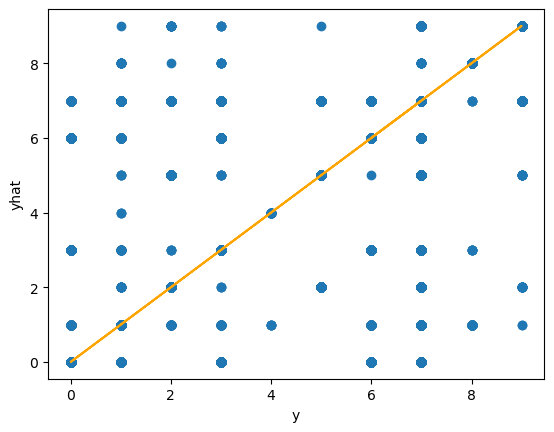

In [47]:
plt.scatter(testBrnli ,yhattest)
plt.xlabel('y'); plt.ylabel('yhat')
plt.plot(yhattest,yhattest,c='orange')
plt.show()

#### Overall the logistic regression model is a tiny bit better than our naive bayes model with a test accuracy of 83.4% compared to 81.3% but one thing that I found interesting is that the logistic regression model had very close accuracies between the train and test sets and this is a good thing because this means that our regression model isn't overfitting to our training set and is pretty good at unseen data.

#### After completeing the Naive Bayes and logistic regression model I ended up trying different methods from class but they all were taking forever to run so I think the best way to proceed is to start from scratch and do some feature selection that isn't just my domain knowledge in order to reduce the amount of features and make things a bit faster.

## Feature Selection + More Cleaning

#### To start I re read in the dataset in order to get a fresh start with all the features.

In [48]:
df = pd.read_csv('rockies2015-2023pitchers.csv')
df.head()

C:\Users\garyp\AppData\Local\Temp\ipykernel_53668\2173081814.py:1: DtypeWarning: Columns (43) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv('rockies2015-2023pitchers.csv')


,pitch_type,game_date,release_speed,release_pos_x,release_pos_z,player_name,batter,pitcher,events,description,...,fld_score,post_away_score,post_home_score,post_bat_score,post_fld_score,if_fielding_alignment,of_fielding_alignment,spin_axis,delta_home_win_exp,delta_run_exp
0,FF,2015-07-24,94.6,-1.62,6.47,"Hawkins, LaTroy",571740,115629,field_out,hit_into_play,...,3,4,3,4,3,Standard,Standard,NaN,0.042,-0.278
1,SL,2015-07-24,90.1,-2.09,6.30,"Hawkins, LaTroy",571740,115629,NaN,foul,...,3,4,3,4,3,Standard,Standard,NaN,0.000,0.000
2,FF,2015-07-24,94.8,-1.81,6.39,"Hawkins, LaTroy",571740,115629,NaN,bunt_foul_tip,...,3,4,3,4,3,Strategic,Strategic,NaN,0.093,-0.161
3,CH,2015-07-24,86.3,-1.76,6.56,"Hawkins, LaTroy",571740,115629,NaN,ball,...,3,4,3,4,3,Strategic,Strategic,NaN,0.000,0.066
4,CH,2015-07-24,87.2,-1.67,6.66,"Hawkins, LaTroy",571740,115629,NaN,ball,...,3,4,3,4,3,Strategic,Strategic,NaN,0.000,0.041


#### I then removed umpire since that was causeing issues as well as removed pitch type since pitch name is the same thing and thats what we are predicting. I also remove the pitches that we removed previously

In [49]:
columnNames = df.columns
columnNames

Index(['pitch_type', 'game_date', 'release_speed', 'release_pos_x',
       'release_pos_z', 'player_name', 'batter', 'pitcher', 'events',
       'description', 'spin_dir', 'spin_rate_deprecated',
       'break_angle_deprecated', 'break_length_deprecated', 'zone', 'des',
       'game_type', 'stand', 'p_throws', 'home_team', 'away_team', 'type',
       'hit_location', 'bb_type', 'balls', 'strikes', 'game_year', 'pfx_x',
       'pfx_z', 'plate_x', 'plate_z', 'on_3b', 'on_2b', 'on_1b',
       'outs_when_up', 'inning', 'inning_topbot', 'hc_x', 'hc_y',
       'tfs_deprecated', 'tfs_zulu_deprecated', 'fielder_2', 'umpire', 'sv_id',
       'vx0', 'vy0', 'vz0', 'ax', 'ay', 'az', 'sz_top', 'sz_bot',
       'hit_distance_sc', 'launch_speed', 'launch_angle', 'effective_speed',
       'release_spin_rate', 'release_extension', 'game_pk', 'pitcher.1',
       'fielder_2.1', 'fielder_3', 'fielder_4', 'fielder_5', 'fielder_6',
       'fielder_7', 'fielder_8', 'fielder_9', 'release_pos_y',
       'estima

In [50]:
df['des']

0         Billy Hamilton grounds out, shortstop Troy Tul...
1         Billy Hamilton grounds out, shortstop Troy Tul...
2         Billy Hamilton grounds out, shortstop Troy Tul...
3         Billy Hamilton grounds out, shortstop Troy Tul...
4         Billy Hamilton grounds out, shortstop Troy Tul...
                                ...                        
189065    Howie Kendrick singles on a line drive to righ...
189066    Jimmy Rollins doubles (6) on a line drive to r...
189067    Jimmy Rollins doubles (6) on a line drive to r...
189068    Joc Pederson lines out to right fielder Carlos...
189069    Joc Pederson lines out to right fielder Carlos...
Name: des, Length: 189070, dtype: object

In [51]:
df = df.drop('pitch_type', axis=1)
df = df.drop('umpire', axis=1)

In [52]:
df = df[df['pitch_name'] != "Slow Curve"]
df = df[df['pitch_name'] !="Pitch Out"]
df = df[df['pitch_name'] != "Eephus"]
df = df[df['pitch_name'] != "Slurve"]
df = df[df['pitch_name'] != "Intentional Ball"]

#### I then looked at missing Values.

In [53]:
nullCount = df.isnull().sum(axis=0)
print(nullCount.sort_values(ascending=False))

spin_dir                   188692
spin_rate_deprecated       188692
tfs_deprecated             188692
tfs_zulu_deprecated        188692
break_length_deprecated    188692
                            ...  
vz0                             0
release_speed                   0
ay                              0
az                              0
ax                              0
Length: 90, dtype: int64


#### I then noticed there are columns with missing values for all observations which is not good so I will remove those columns

In [54]:
df = df.dropna(axis=1, how='all')

In [55]:
nullCount = df.isnull().sum(axis=0)
print(nullCount.sort_values(ascending=False))

on_3b                              169031
launch_speed_angle                 154408
estimated_woba_using_speedangle    154408
estimated_ba_using_speedangle      154408
hc_y                               154392
                                    ...  
vz0                                     0
ax                                      0
ay                                      0
az                                      0
sz_top                                  0
Length: 84, dtype: int64


#### There was still a lot of columns with a high number of null values so I will remove all columns with the amount of null values > 1000

In [56]:
for col in df.columns:
    if df[col].isnull().sum() > 10000:
        df.drop(col, axis=1, inplace=True)

In [57]:
nullCount = df.isnull().sum(axis=0)
print(nullCount.sort_values(ascending=False))

release_spin_rate        5311
of_fielding_alignment    2054
if_fielding_alignment    2054
effective_speed          1306
release_extension        1294
                         ... 
vx0                         0
vy0                         0
vz0                         0
ax                          0
az                          0
Length: 64, dtype: int64


#### I then looked at how many features we have 

In [58]:
numColumns = df.shape[1]
numColumns - 1

63

#### Thats better but now I will drop the observations that have null values since there isn't many now

In [59]:
df = df.dropna()
df.shape

(182543, 64)

In [60]:
pd.set_option('display.max_columns', None)
df.head()

,game_date,release_speed,release_pos_x,release_pos_z,player_name,batter,pitcher,description,zone,des,game_type,stand,p_throws,home_team,away_team,type,balls,strikes,game_year,pfx_x,pfx_z,plate_x,plate_z,outs_when_up,inning,inning_topbot,fielder_2,vx0,vy0,vz0,ax,ay,az,sz_top,sz_bot,effective_speed,release_spin_rate,release_extension,game_pk,pitcher.1,fielder_2.1,fielder_3,fielder_4,fielder_5,fielder_6,fielder_7,fielder_8,fielder_9,release_pos_y,at_bat_number,pitch_number,pitch_name,home_score,away_score,bat_score,fld_score,post_away_score,post_home_score,post_bat_score,post_fld_score,if_fielding_alignment,of_fielding_alignment,delta_home_win_exp,delta_run_exp
0,2015-07-24,94.6,-1.62,6.47,"Hawkins, LaTroy",571740,115629,hit_into_play,7,"Billy Hamilton grounds out, shortstop Troy Tul...",R,L,R,COL,CIN,X,2,2,2015,-0.56,0.89,-0.78,2.18,2,8,Top,460026,3.632060,-138.186573,-6.902819,-7.659,21.917,-19.761,3.49,1.60,95.3,2090.0,6.2,415087,115629,460026,572019,518934,571448,453064,572816,453568,471865,54.5,65,6,4-Seam Fastball,3,4,4,3,4,3,4,3,Standard,Standard,0.042,-0.278
1,2015-07-24,90.1,-2.09,6.30,"Hawkins, LaTroy",571740,115629,foul,9,"Billy Hamilton grounds out, shortstop Troy Tul...",R,L,R,COL,CIN,S,2,2,2015,-0.06,0.34,0.51,2.01,2,8,Top,460026,6.622246,-131.895870,-4.395065,-2.139,28.148,-27.449,3.49,1.60,89.1,2153.0,5.9,415087,115629,460026,572019,518934,571448,453064,572816,453568,471865,54.5,65,5,Slider,3,4,4,3,4,3,4,3,Standard,Standard,0.000,0.000
2,2015-07-24,94.8,-1.81,6.39,"Hawkins, LaTroy",571740,115629,bunt_foul_tip,5,"Billy Hamilton grounds out, shortstop Troy Tul...",R,L,R,COL,CIN,S,2,1,2015,-1.06,0.74,0.16,2.23,1,8,Top,460026,7.909509,-138.636926,-6.049714,-14.965,30.756,-21.558,3.49,1.60,94.2,2062.0,6.2,415087,115629,460026,572019,518934,571448,453064,572816,453568,471865,54.5,65,4,4-Seam Fastball,3,4,4,3,4,3,4,3,Strategic,Strategic,0.093,-0.161
3,2015-07-24,86.3,-1.76,6.56,"Hawkins, LaTroy",571740,115629,ball,13,"Billy Hamilton grounds out, shortstop Troy Tul...",R,L,R,COL,CIN,B,1,1,2015,-0.77,0.47,-1.23,2.29,1,8,Top,460026,3.117415,-126.476901,-3.905973,-8.666,24.784,-26.552,3.66,1.83,85.8,1695.0,6.0,415087,115629,460026,572019,518934,571448,453064,572816,453568,471865,54.5,65,3,Changeup,3,4,4,3,4,3,4,3,Strategic,Strategic,0.000,0.066
4,2015-07-24,87.2,-1.67,6.66,"Hawkins, LaTroy",571740,115629,ball,13,"Billy Hamilton grounds out, shortstop Troy Tul...",R,L,R,COL,CIN,B,0,1,2015,-0.99,0.87,-0.09,1.14,1,8,Top,460026,6.177315,-127.486190,-8.029063,-11.725,25.075,-21.426,3.64,1.78,86.5,1794.0,6.0,415087,115629,460026,572019,518934,571448,453064,572816,453568,471865,54.5,65,2,Changeup,3,4,4,3,4,3,4,3,Strategic,Strategic,0.000,0.041


#### I then took out all features that have nothing to do with pitch name or things that shouldn't or can't be encoded

In [61]:
columnNames = df.columns
columnNames

Index(['game_date', 'release_speed', 'release_pos_x', 'release_pos_z',
       'player_name', 'batter', 'pitcher', 'description', 'zone', 'des',
       'game_type', 'stand', 'p_throws', 'home_team', 'away_team', 'type',
       'balls', 'strikes', 'game_year', 'pfx_x', 'pfx_z', 'plate_x', 'plate_z',
       'outs_when_up', 'inning', 'inning_topbot', 'fielder_2', 'vx0', 'vy0',
       'vz0', 'ax', 'ay', 'az', 'sz_top', 'sz_bot', 'effective_speed',
       'release_spin_rate', 'release_extension', 'game_pk', 'pitcher.1',
       'fielder_2.1', 'fielder_3', 'fielder_4', 'fielder_5', 'fielder_6',
       'fielder_7', 'fielder_8', 'fielder_9', 'release_pos_y', 'at_bat_number',
       'pitch_number', 'pitch_name', 'home_score', 'away_score', 'bat_score',
       'fld_score', 'post_away_score', 'post_home_score', 'post_bat_score',
       'post_fld_score', 'if_fielding_alignment', 'of_fielding_alignment',
       'delta_home_win_exp', 'delta_run_exp'],
      dtype='object')

#### Looking at the outputs of the columns I am going to take out game_date, player_name since each player has a unique number assigned already, des, game_type, game_year, description and inning_topbot.

In [62]:
predictorColumns = [ 'pitch_name', 'release_speed', 'release_pos_x', 'release_pos_z',
        'batter', 'pitcher', 'zone',
        'stand', 'p_throws', 'home_team', 'away_team', 'type',
       'balls', 'strikes', 'pfx_x', 'pfx_z', 'plate_x', 'plate_z',
       'outs_when_up', 'inning', 'fielder_2', 'vx0', 'vy0',
       'vz0', 'ax', 'ay', 'az', 'sz_top', 'sz_bot', 'effective_speed',
       'release_spin_rate', 'release_extension', 'game_pk', 'pitcher.1',
       'fielder_2.1', 'fielder_3', 'fielder_4', 'fielder_5', 'fielder_6',
       'fielder_7', 'fielder_8', 'fielder_9', 'release_pos_y', 'at_bat_number',
       'pitch_number', 'home_score', 'away_score', 'bat_score',
       'fld_score', 'post_away_score', 'post_home_score', 'post_bat_score',
       'post_fld_score', 'if_fielding_alignment', 'of_fielding_alignment',
       'delta_home_win_exp', 'delta_run_exp']
df = df[predictorColumns]
print(df.shape)
df.head()

(182543, 57)


,pitch_name,release_speed,release_pos_x,release_pos_z,batter,pitcher,zone,stand,p_throws,home_team,away_team,type,balls,strikes,pfx_x,pfx_z,plate_x,plate_z,outs_when_up,inning,fielder_2,vx0,vy0,vz0,ax,ay,az,sz_top,sz_bot,effective_speed,release_spin_rate,release_extension,game_pk,pitcher.1,fielder_2.1,fielder_3,fielder_4,fielder_5,fielder_6,fielder_7,fielder_8,fielder_9,release_pos_y,at_bat_number,pitch_number,home_score,away_score,bat_score,fld_score,post_away_score,post_home_score,post_bat_score,post_fld_score,if_fielding_alignment,of_fielding_alignment,delta_home_win_exp,delta_run_exp
0,4-Seam Fastball,94.6,-1.62,6.47,571740,115629,7,L,R,COL,CIN,X,2,2,-0.56,0.89,-0.78,2.18,2,8,460026,3.632060,-138.186573,-6.902819,-7.659,21.917,-19.761,3.49,1.60,95.3,2090.0,6.2,415087,115629,460026,572019,518934,571448,453064,572816,453568,471865,54.5,65,6,3,4,4,3,4,3,4,3,Standard,Standard,0.042,-0.278
1,Slider,90.1,-2.09,6.30,571740,115629,9,L,R,COL,CIN,S,2,2,-0.06,0.34,0.51,2.01,2,8,460026,6.622246,-131.895870,-4.395065,-2.139,28.148,-27.449,3.49,1.60,89.1,2153.0,5.9,415087,115629,460026,572019,518934,571448,453064,572816,453568,471865,54.5,65,5,3,4,4,3,4,3,4,3,Standard,Standard,0.000,0.000
2,4-Seam Fastball,94.8,-1.81,6.39,571740,115629,5,L,R,COL,CIN,S,2,1,-1.06,0.74,0.16,2.23,1,8,460026,7.909509,-138.636926,-6.049714,-14.965,30.756,-21.558,3.49,1.60,94.2,2062.0,6.2,415087,115629,460026,572019,518934,571448,453064,572816,453568,471865,54.5,65,4,3,4,4,3,4,3,4,3,Strategic,Strategic,0.093,-0.161
3,Changeup,86.3,-1.76,6.56,571740,115629,13,L,R,COL,CIN,B,1,1,-0.77,0.47,-1.23,2.29,1,8,460026,3.117415,-126.476901,-3.905973,-8.666,24.784,-26.552,3.66,1.83,85.8,1695.0,6.0,415087,115629,460026,572019,518934,571448,453064,572816,453568,471865,54.5,65,3,3,4,4,3,4,3,4,3,Strategic,Strategic,0.000,0.066
4,Changeup,87.2,-1.67,6.66,571740,115629,13,L,R,COL,CIN,B,0,1,-0.99,0.87,-0.09,1.14,1,8,460026,6.177315,-127.486190,-8.029063,-11.725,25.075,-21.426,3.64,1.78,86.5,1794.0,6.0,415087,115629,460026,572019,518934,571448,453064,572816,453568,471865,54.5,65,2,3,4,4,3,4,3,4,3,Strategic,Strategic,0.000,0.041


#### I then encoded our categorical variables and set up the train and test split

In [63]:
data_randomized = df.sample(frac=1) 
trainsize = round(len(data_randomized) * 0.7)
training_set = data_randomized[:trainsize].reset_index(drop=True)
test_set = data_randomized[trainsize:].reset_index(drop=True)
print(training_set.shape)
print(test_set.shape)


training_set['pitch_name'].value_counts(normalize=True)

test_set['pitch_name'].value_counts(normalize=True)

trainX = training_set.iloc[:, 1:]
trainY = training_set['pitch_name']

colnamestrain = trainX.columns

trainX.head()

trainY.head()

test_set.head()

testX = test_set.iloc[:,1:]
testY = test_set['pitch_name']
colnames = testX.columns
testX.head()
testY.head()

trainBrnli = le.fit_transform(trainY)
trainBrnli[:5]

le = LabelEncoder()
testBrnli = le.fit_transform(testY)


enc = OrdinalEncoder()
testX = enc.fit_transform(testX)
testX = pd.DataFrame(testX, columns=colnames)
print(testX.shape)
testX.head()


(127780, 57)
(54763, 57)
(54763, 56)


,release_speed,release_pos_x,release_pos_z,batter,pitcher,zone,stand,p_throws,home_team,away_team,type,balls,strikes,pfx_x,pfx_z,plate_x,plate_z,outs_when_up,inning,fielder_2,vx0,vy0,vz0,ax,ay,az,sz_top,sz_bot,effective_speed,release_spin_rate,release_extension,game_pk,pitcher.1,fielder_2.1,fielder_3,fielder_4,fielder_5,fielder_6,fielder_7,fielder_8,fielder_9,release_pos_y,at_bat_number,pitch_number,home_score,away_score,bat_score,fld_score,post_away_score,post_home_score,post_bat_score,post_fld_score,if_fielding_alignment,of_fielding_alignment,delta_home_win_exp,delta_run_exp
0,81.0,809.0,250.0,942.0,64.0,10.0,1.0,0.0,7.0,14.0,0.0,2.0,1.0,281.0,241.0,411.0,434.0,2.0,8.0,8.0,7426.0,53823.0,44557.0,42109.0,905.0,17845.0,71.0,47.0,109.0,771.0,38.0,1239.0,64.0,8.0,13.0,10.0,12.0,19.0,23.0,6.0,16.0,28.0,81.0,3.0,6.0,6.0,6.0,6.0,6.0,6.0,6.0,6.0,2.0,1.0,275.0,826.0
1,212.0,700.0,201.0,388.0,36.0,4.0,1.0,0.0,20.0,7.0,2.0,0.0,0.0,321.0,259.0,311.0,373.0,2.0,1.0,2.0,3461.0,30261.0,29911.0,50228.0,34289.0,28026.0,65.0,49.0,205.0,1213.0,18.0,49.0,36.0,2.0,9.0,5.0,7.0,5.0,18.0,2.0,4.0,177.0,16.0,0.0,0.0,2.0,0.0,2.0,2.0,1.0,1.0,2.0,2.0,1.0,390.0,1390.0
2,267.0,357.0,182.0,255.0,71.0,10.0,0.0,1.0,7.0,1.0,1.0,0.0,1.0,177.0,277.0,388.0,473.0,0.0,8.0,1.0,38175.0,10348.0,35609.0,20452.0,26263.0,35536.0,74.0,57.0,280.0,1296.0,24.0,688.0,71.0,1.0,10.0,15.0,7.0,11.0,26.0,0.0,23.0,165.0,70.0,1.0,5.0,4.0,4.0,5.0,4.0,5.0,4.0,5.0,1.0,2.0,275.0,695.0
3,182.0,762.0,193.0,811.0,60.0,8.0,1.0,0.0,7.0,4.0,1.0,1.0,0.0,281.0,238.0,331.0,348.0,0.0,1.0,9.0,4365.0,40368.0,27620.0,45028.0,5765.0,21786.0,63.0,57.0,196.0,385.0,26.0,353.0,60.0,9.0,4.0,5.0,7.0,11.0,2.0,5.0,3.0,147.0,9.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0,1.0,275.0,664.0
4,243.0,719.0,209.0,281.0,32.0,10.0,1.0,0.0,7.0,22.0,0.0,1.0,1.0,310.0,238.0,379.0,534.0,2.0,8.0,2.0,5785.0,18286.0,50238.0,49945.0,48545.0,22152.0,72.0,57.0,237.0,1431.0,22.0,162.0,32.0,2.0,4.0,5.0,7.0,11.0,6.0,2.0,4.0,177.0,86.0,2.0,5.0,11.0,11.0,5.0,11.0,5.0,11.0,5.0,2.0,1.0,275.0,816.0


In [64]:
enc = OrdinalEncoder()
trainX = enc.fit_transform(trainX)
trainX = pd.DataFrame(trainX, columns=colnames)
print(trainX.shape)
trainX.head()

(127780, 56)


,release_speed,release_pos_x,release_pos_z,batter,pitcher,zone,stand,p_throws,home_team,away_team,type,balls,strikes,pfx_x,pfx_z,plate_x,plate_z,outs_when_up,inning,fielder_2,vx0,vy0,vz0,ax,ay,az,sz_top,sz_bot,effective_speed,release_spin_rate,release_extension,game_pk,pitcher.1,fielder_2.1,fielder_3,fielder_4,fielder_5,fielder_6,fielder_7,fielder_8,fielder_9,release_pos_y,at_bat_number,pitch_number,home_score,away_score,bat_score,fld_score,post_away_score,post_home_score,post_bat_score,post_fld_score,if_fielding_alignment,of_fielding_alignment,delta_home_win_exp,delta_run_exp
0,167.0,395.0,291.0,172.0,12.0,12.0,1.0,1.0,7.0,1.0,0.0,0.0,0.0,131.0,295.0,365.0,270.0,2.0,5.0,2.0,84284.0,107990.0,12557.0,28221.0,50278.0,71171.0,94.0,54.0,168.0,923.0,22.0,70.0,12.0,2.0,9.0,5.0,7.0,2.0,18.0,2.0,6.0,190.0,49.0,0.0,8.0,4.0,4.0,8.0,4.0,8.0,4.0,8.0,2.0,1.0,314.0,849.0
1,147.0,276.0,129.0,1252.0,98.0,4.0,1.0,1.0,13.0,7.0,1.0,1.0,0.0,328.0,204.0,337.0,402.0,2.0,4.0,14.0,58503.0,116818.0,117473.0,101268.0,21904.0,21109.0,76.0,64.0,172.0,1532.0,33.0,1032.0,98.0,14.0,31.0,15.0,12.0,19.0,32.0,15.0,11.0,102.0,38.0,1.0,4.0,1.0,4.0,1.0,1.0,4.0,4.0,1.0,3.0,1.0,314.0,815.0
2,137.0,367.0,261.0,479.0,92.0,7.0,0.0,1.0,22.0,7.0,2.0,0.0,1.0,221.0,60.0,316.0,391.0,0.0,1.0,3.0,53107.0,119874.0,115167.0,62734.0,15571.0,650.0,114.0,83.0,130.0,1517.0,12.0,771.0,92.0,3.0,10.0,13.0,7.0,11.0,2.0,15.0,2.0,313.0,9.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0,1.0,352.0,1273.0
3,165.0,259.0,142.0,757.0,21.0,12.0,1.0,1.0,1.0,7.0,0.0,3.0,2.0,336.0,191.0,465.0,323.0,1.0,7.0,1.0,97828.0,110832.0,99992.0,102216.0,58666.0,18348.0,86.0,67.0,176.0,2052.0,27.0,636.0,21.0,1.0,3.0,5.0,7.0,13.0,6.0,2.0,23.0,160.0,65.0,5.0,0.0,2.0,0.0,2.0,2.0,0.0,0.0,2.0,2.0,1.0,391.0,1144.0
4,264.0,283.0,230.0,283.0,71.0,7.0,0.0,1.0,24.0,7.0,1.0,2.0,0.0,73.0,270.0,306.0,366.0,0.0,4.0,2.0,119148.0,40592.0,37205.0,2346.0,103245.0,68507.0,59.0,52.0,272.0,1434.0,28.0,7.0,71.0,2.0,1.0,5.0,7.0,2.0,19.0,2.0,4.0,190.0,40.0,2.0,0.0,3.0,0.0,3.0,3.0,0.0,0.0,3.0,2.0,1.0,314.0,780.0


#### Finally I will now use correlation coefficents to select any variables that have a correlation coefficient of 0.5 and above in order to reduce the amount of features

In [65]:
corrMatrix = pd.DataFrame(trainX).corrwith(pd.Series(trainBrnli))
corrList = corrMatrix.abs().sort_values(ascending=False)
corrList

az                       0.601827
pfx_z                    0.508738
vy0                      0.414882
effective_speed          0.368393
release_speed            0.366953
vz0                      0.286482
ay                       0.276802
release_spin_rate        0.223400
release_pos_z            0.197812
plate_z                  0.185833
ax                       0.168525
pfx_x                    0.162777
game_pk                  0.125353
fielder_5                0.112636
release_extension        0.109671
fielder_4                0.107394
fielder_8                0.103389
zone                     0.099788
fielder_3                0.097660
fielder_6                0.093052
fielder_7                0.088739
vx0                      0.085789
fielder_2.1              0.085640
fielder_2                0.085640
release_pos_y            0.083754
batter                   0.079724
fielder_9                0.078561
at_bat_number            0.064324
inning                   0.063529
strikes       

In [66]:
featureList = corrList[corrList > 0.1].index.tolist()
featureList

['az',
 'pfx_z',
 'vy0',
 'effective_speed',
 'release_speed',
 'vz0',
 'ay',
 'release_spin_rate',
 'release_pos_z',
 'plate_z',
 'ax',
 'pfx_x',
 'game_pk',
 'fielder_5',
 'release_extension',
 'fielder_4',
 'fielder_8']

#### Now I will take out the features that werent selected

In [67]:
trainX = trainX[featureList]
trainX

,az,pfx_z,vy0,effective_speed,release_speed,vz0,ay,release_spin_rate,release_pos_z,plate_z,ax,pfx_x,game_pk,fielder_5,release_extension,fielder_4,fielder_8
0,71171.0,295.0,107990.0,168.0,167.0,12557.0,50278.0,923.0,291.0,270.0,28221.0,131.0,70.0,7.0,22.0,5.0,2.0
1,21109.0,204.0,116818.0,172.0,147.0,117473.0,21904.0,1532.0,129.0,402.0,101268.0,328.0,1032.0,12.0,33.0,15.0,15.0
2,650.0,60.0,119874.0,130.0,137.0,115167.0,15571.0,1517.0,261.0,391.0,62734.0,221.0,771.0,7.0,12.0,13.0,15.0
3,18348.0,191.0,110832.0,176.0,165.0,99992.0,58666.0,2052.0,142.0,323.0,102216.0,336.0,636.0,7.0,27.0,5.0,2.0
4,68507.0,270.0,40592.0,272.0,264.0,37205.0,103245.0,1434.0,230.0,366.0,2346.0,73.0,7.0,7.0,28.0,5.0,2.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
127775,97358.0,309.0,5272.0,311.0,312.0,37367.0,98771.0,1377.0,250.0,477.0,5918.0,100.0,387.0,7.0,19.0,5.0,2.0
127776,83253.0,302.0,63493.0,261.0,246.0,49255.0,44993.0,1389.0,211.0,421.0,108296.0,314.0,468.0,7.0,25.0,5.0,2.0
127777,113028.0,351.0,4652.0,322.0,314.0,6058.0,104154.0,1645.0,210.0,365.0,115721.0,347.0,397.0,7.0,25.0,5.0,2.0
127778,100765.0,319.0,41845.0,283.0,270.0,3650.0,50804.0,1577.0,224.0,294.0,102835.0,291.0,581.0,7.0,23.0,11.0,2.0


In [68]:
testX = testX[featureList]
testX

,az,pfx_z,vy0,effective_speed,release_speed,vz0,ay,release_spin_rate,release_pos_z,plate_z,ax,pfx_x,game_pk,fielder_5,release_extension,fielder_4,fielder_8
0,17845.0,241.0,53823.0,109.0,81.0,44557.0,905.0,771.0,250.0,434.0,42109.0,281.0,1239.0,12.0,38.0,10.0,6.0
1,28026.0,259.0,30261.0,205.0,212.0,29911.0,34289.0,1213.0,201.0,373.0,50228.0,321.0,49.0,7.0,18.0,5.0,2.0
2,35536.0,277.0,10348.0,280.0,267.0,35609.0,26263.0,1296.0,182.0,473.0,20452.0,177.0,688.0,7.0,24.0,15.0,0.0
3,21786.0,238.0,40368.0,196.0,182.0,27620.0,5765.0,385.0,193.0,348.0,45028.0,281.0,353.0,7.0,26.0,5.0,5.0
4,22152.0,238.0,18286.0,237.0,243.0,50238.0,48545.0,1431.0,209.0,534.0,49945.0,310.0,162.0,7.0,22.0,5.0,2.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
54758,47863.0,310.0,2208.0,286.0,287.0,5414.0,48702.0,241.0,245.0,376.0,7835.0,126.0,285.0,7.0,23.0,4.0,2.0
54759,45683.0,305.0,5805.0,289.0,278.0,21077.0,35058.0,1233.0,212.0,460.0,17038.0,164.0,1207.0,12.0,24.0,10.0,20.0
54760,22881.0,233.0,22692.0,234.0,234.0,25413.0,41336.0,1075.0,233.0,373.0,5102.0,91.0,90.0,7.0,22.0,5.0,2.0
54761,23883.0,255.0,48559.0,157.0,141.0,33399.0,12428.0,381.0,262.0,428.0,42271.0,274.0,959.0,14.0,30.0,12.0,15.0


## Random Forest

In [69]:
from sklearn.ensemble import RandomForestClassifier
model = RandomForestClassifier()model.fit(trainX ,trainBrnli)

RandomForestClassifier()

In [70]:
yhattrain = model.predict(trainX)

In [71]:
pd.crosstab(yhattrain, trainY)

pitch_name,4-Seam Fastball,Changeup,Curveball,Cutter,Forkball,Knuckle Curve,Sinker,Slider,Split-Finger,Sweeper
row_0,,,,,,,,,,
0,51402,0,0,0,0,0,0,0,0,0
1,0,12431,0,0,0,0,0,0,0,0
2,0,0,7281,0,0,0,0,0,0,0
3,0,0,0,8433,0,0,0,0,0,0
4,0,0,0,0,115,0,0,0,0,0
5,0,0,0,0,0,4100,0,0,0,0
6,0,0,0,0,0,0,18028,0,0,0
7,0,0,0,0,0,0,0,22740,0,0
8,0,0,0,0,0,0,0,0,1212,0


In [72]:
accuracy_score(yhattrain, trainBrnli)

1.0

In [73]:
yhattest = model.predict(testX)

In [74]:
pd.crosstab(yhattest, testY)

pitch_name,4-Seam Fastball,Changeup,Curveball,Cutter,Forkball,Knuckle Curve,Sinker,Slider,Split-Finger,Sweeper
row_0,,,,,,,,,,
0,13141,32,2,449,0,0,494,215,6,0
1,717,4620,87,692,48,17,450,2445,76,24
2,0,48,2415,2,0,121,0,150,6,64
3,333,3,0,544,0,0,196,40,0,0
4,0,0,0,0,8,0,0,0,0,0
5,0,0,157,2,0,1461,0,146,0,1
6,7182,40,15,509,0,5,5056,515,0,22
7,657,584,408,1382,0,197,1495,6282,421,669
9,0,0,0,0,0,0,0,0,0,112


In [75]:
accuracy_score(yhattest, testBrnli)

0.6142651060022278

#### With the default of 100 trees the model is overfit and this is shown with the train set having 100% accuracy. In order to try and fix this i wil reduce the depth and also try and test a buch of different values for the trees to find a good balance

In [76]:
ns = np.arange(1, 200, 10)
trainaccuracies = []
testaccuracies = []

for n in ns:
    models = RandomForestClassifier(n_estimators=n)
    models.fit(trainX, trainY)
    yhattrain = models.predict(trainX)
    yhattest = models.predict(testX)
    trainacc = accuracy_score(trainY, yhattrain)
    testacc = accuracy_score(testY, yhattest)
    trainaccuracies.append(trainacc)
    testaccuracies.append(testacc)

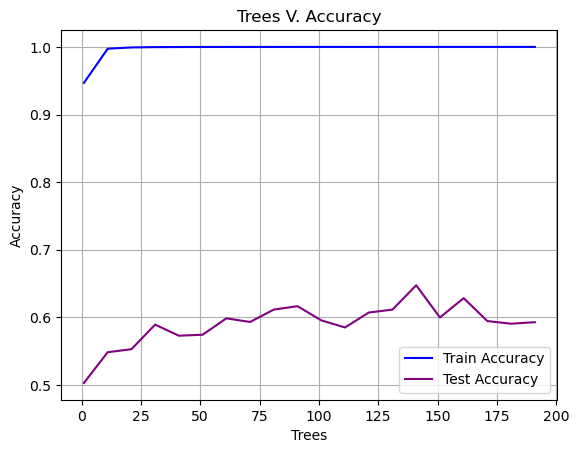

In [77]:
plt.plot(ns, trainaccuracies, label='Train Accuracy', color = 'blue')
plt.plot(ns, testaccuracies, label='Test Accuracy',color = 'purple')
plt.xlabel('Trees')
plt.ylabel('Accuracy')
plt.title('Trees V. Accuracy')
plt.legend()
plt.grid()
plt.show()

In [79]:
maxtestacc = np.max(testaccuracies)
maxtestacc


0.64751748443292

In [80]:
numberTrees = ns[np.argmax(testaccuracies)]
numberTrees

141

In [81]:
ns = np.arange(1, 40, 5)
trainaccuracies = []
testaccuracies = []

for n in ns:
    models = RandomForestClassifier(n_estimators=numberTrees, max_depth = n)
    models.fit(trainX, trainY)
    yhattrain = models.predict(trainX)
    yhattest = models.predict(testX)
    trainacc = accuracy_score(trainY, yhattrain)
    testacc = accuracy_score(testY, yhattest)
    trainaccuracies.append(trainacc)
    testaccuracies.append(testacc)

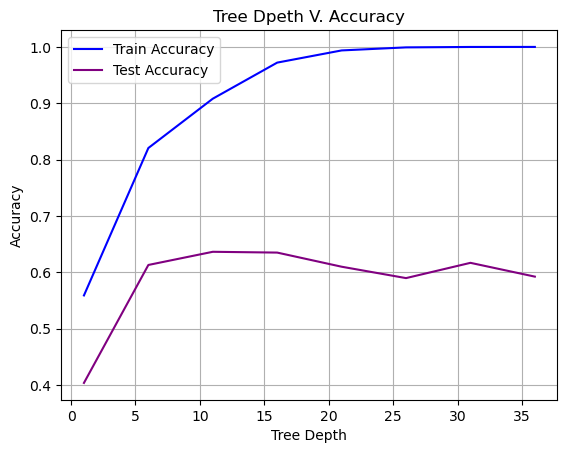

In [82]:
plt.plot(ns, trainaccuracies, label='Train Accuracy', color = 'blue')
plt.plot(ns, testaccuracies, label='Test Accuracy',color = 'purple')
plt.xlabel('Tree Depth')
plt.ylabel('Accuracy')
plt.title('Tree Dpeth V. Accuracy')
plt.legend()
plt.grid()
plt.show()

In [83]:
maxtestacc = np.max(testaccuracies)
maxtestacc

0.636451618793711

In [84]:
depthnum = ns[np.argmax(testaccuracies)]
depthnum

11

In [ ]:
from sklearn.ensemble import RandomForestClassifier
model = RandomForestClassifier(n_estimators=numberTrees,max_depth = depthnum)
model.fit(trainX ,trainBrnli)

In [ ]:
yhattrain = model.predict(trainX)

In [ ]:
pd.crosstab(yhattrain, trainY)

In [ ]:
accuracy_score(yhattrain, trainBrnli)

In [ ]:
yhattest = model.predict(testX)

In [ ]:
pd.crosstab(yhattest, testY)

In [ ]:
accuracy_score(yhattest, testBrnli)

#### Overall the random forest model did worse than the other two models but not by all that much. I think that if I had more time I could tune the model more and get a better performance out of it.

## Conclusion

#### Overall I am a lot happier with the results from this project as compared to the last one. Even though I was predicting the same thing which was pitch name for the Colorado Rockies I ended up expanding the data set by expanding the year ranges from just 2023 to 2015 - 2023. This helped make the models I had previously used more accurate and made the new models just as good. I think if I were to have more time I would probably test neural nets because the logistic regression model performed the best and neural nets are just a bunch of logistic regressions. This time around it took a lot longer to clean because since there was so much more data it made running the more complex models almost impossible since there is so much data. This made it so that I had to reduce the number of features for the random forest model which makes this comparison not as accurate but, my computer couldn't handle trying to find the best hyper parameters without reducing the dimensionality. Overall I'm pleased with the results but, there are a lot more things I could do with this data set.

# References

#### Baseball Savant
<a href="https://baseballsavant.mlb.com/statcast_search?hfPT=FF%7CSI%7CFC%7CCH%7CFS%7CFO%7CSC%7CCU%7CKC%7CCS%7CSL%7CST%7CSV%7CKN%7CEP%7CIN%7CPO%7C&hfAB=&hfGT=R%7C&hfPR=&hfZ=&hfStadium=&hfBBL=&hfNewZones=&hfPull=&hfC=00%7C01%7C02%7C10%7C11%7C12%7C20%7C21%7C22%7C30%7C31%7C32%7C&hfSea=2023%7C2022%7C2021%7C2019%7C2018%7C2017%7C2016%7C2015%7C&hfSit=&player_type=pitcher&hfOuts=&hfOpponent=&pitcher_throws=&batter_stands=&hfSA=&game_date_gt=&game_date_lt=&hfMo=&hfTeam=COL%7C&home_road=&hfRO=&position=&hfInfield=&hfOutfield=&hfInn=&hfBBT=&hfFlag=&metric_1=&group_by=name&min_pitches=0&min_results=0&min_pas=0&sort_col=pitches&player_event_sort=api_p_release_speed&sort_order=desc&chk_stats_velocity=on&chk_stats_effective_speed=on&chk_stats_spin_rate=on&chk_stats_release_pos_z=on&chk_stats_release_pos_x=on&chk_stats_release_extension=on&chk_stats_plate_x=on&chk_stats_plate_z=on#results">Where I Got My Data</a>

#### Baseball Savant CSV Documentation
<a href="https://baseballsavant.mlb.com/csv-docs">CSV documentation</a>